# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
K_SIZE = 5

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

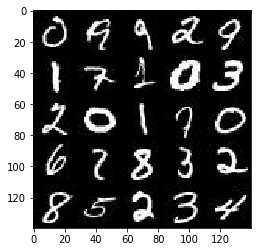

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

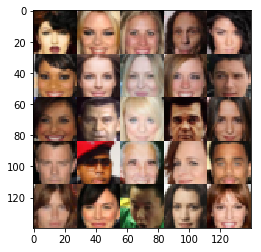

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)
                                 

    return input_image, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2, conv_kernel_size = K_SIZE):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #depth=3
        conv_layer_1 = tf.layers.conv2d(images, filters = 64, kernel_size = conv_kernel_size, strides = 2, padding='same')
        relu_layer_1 = tf.maximum(alpha * conv_layer_1, conv_layer_1)
        
        conv_layer_2 = tf.layers.conv2d(relu_layer_1, filters = 128, kernel_size = conv_kernel_size, strides = 2, padding='same')
        bn_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        relu_layer_2 = tf.maximum(alpha * bn_layer_2, bn_layer_2)
        
        conv_layer_3 = tf.layers.conv2d(bn_layer_2, filters = 256, kernel_size = conv_kernel_size, strides = 2, padding='same')
        bn_layer_3 = tf.layers.batch_normalization(conv_layer_3, training=True)
        relu_layer_3 = tf.maximum(alpha * bn_layer_3, bn_layer_3)
        
        conv_layer_4 = tf.layers.conv2d(bn_layer_3, filters = 512, kernel_size = conv_kernel_size, strides = 2, padding='same')
        bn_layer_4 = tf.layers.batch_normalization(conv_layer_4, training=True)
        relu_layer_4 = tf.maximum(alpha * bn_layer_4, bn_layer_4)
        
        #figure out how big the data is
        x_shape = relu_layer_3.get_shape()
        n_data = 1
        for n_dim in x_shape[1:]:
            n_data = n_data * int(n_dim)
        
        dense_input = tf.reshape(relu_layer_3, [-1, n_data])
        
        logits = tf.layers.dense(dense_input, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = .2, conv_kernel_size = K_SIZE):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        start_size = int(z.get_shape()[1])
        
        output_w_h = 28
        start_w_h = output_w_h // 4
        #in order to preserve a 28x28x3 output but still have the same number of convolutional transpose as convolutional
        #layers, I alternate 2 and 1 stride levels
        x = tf.layers.dense(z, start_size*start_w_h*start_w_h)
        x = tf.reshape(x, (-1, start_w_h,start_w_h,start_size))
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 512, kernel_size = conv_kernel_size, strides = 1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 256, kernel_size = conv_kernel_size, strides = 2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 128, kernel_size = conv_kernel_size, strides = 1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = 64, kernel_size = conv_kernel_size, strides = 2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, filters = out_channel_dim, kernel_size = conv_kernel_size, strides = 1, padding='same')
#         x = tf.layers.batch_normalization(x, training=is_train)
#         x = tf.maximum(alpha * x, x)
        
        # Output layer, 32x32x3
        logits = x
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, label_smoothing_parameter = .9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_output_train  = generator(input_z, out_channel_dim, is_train=True)
    
    disc_output_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_output_fake, disc_logits_fake = discriminator(gen_output_train, reuse=True)
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_logits_fake)))
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_logits_fake) * label_smoothing_parameter))
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_logits_fake)))
    
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    all_vars = tf.trainable_variables()
    disc_vars = [x for x in all_vars if x.name.startswith('discriminator')]
    gen_vars = [x for x in all_vars if x.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # Optimize
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list=gen_vars)

    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    real_data, z_data, lr_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    
    disc_loss, gen_loss = model_loss(real_data, z_data, image_channels)
    
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    gen_loss_list = []
    disc_loss_list = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            batch_counter = 0
            for batch_images in get_batches(batch_size):
                #scale image values to be between 1 and -1
                batch_images = 2 * batch_images
                #figure out inputs
                z_data_values = np.random.uniform(-1, 1, (batch_size, z_dim))
#                 z_data_values = np.random.normal(loc=0.0, scale=.1, size=(batch_size, z_dim))
                input_values_dict = {real_data : batch_images, z_data : z_data_values, lr_tensor : learning_rate}
                
                #run optimizers
                _ = sess.run(disc_opt, feed_dict = {real_data : batch_images, z_data : z_data_values, lr_tensor : learning_rate})
                _ = sess.run(gen_opt, feed_dict = {real_data : batch_images, z_data : z_data_values, lr_tensor : learning_rate})
                
                if batch_counter % 10 == 0:
                    #calculate loss
                    disc_loss_val, gen_loss_val = sess.run([disc_loss, gen_loss], feed_dict = input_values_dict)
                    gen_loss_list.append(gen_loss_val)
                    disc_loss_list.append(disc_loss_val)
                    print("epoch {} / {} \t batch {} / {} \t generator loss: {} \t discriminator loss: {}".format(epoch_i + 1, epoch_count, batch_counter, '?', gen_loss_val, disc_loss_val))
                if batch_counter % 100 == 0:
                    #plot
                    show_generator_output(sess, n_images=25, input_z=z_data, out_channel_dim=image_channels, image_mode=data_image_mode)
                    
                    
                batch_counter += 1
        show_generator_output(sess, n_images=25, input_z=z_data, out_channel_dim=image_channels, image_mode=data_image_mode)
                    
                
    plt.figure()
    plt.plot(gen_loss_list, label="Gen Loss")
    plt.plot(disc_loss_list, label="Disc Loss")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1 / 2 	 batch 0 / ? 	 generator loss: 0.005098132416605949 	 discriminator loss: 6.012998104095459


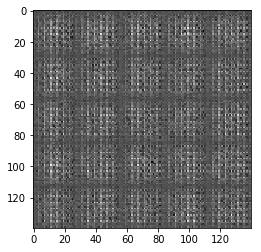

epoch 1 / 2 	 batch 10 / ? 	 generator loss: 1.4045586585998535 	 discriminator loss: 0.7539976239204407
epoch 1 / 2 	 batch 20 / ? 	 generator loss: 2.2239389419555664 	 discriminator loss: 0.4773399829864502
epoch 1 / 2 	 batch 30 / ? 	 generator loss: 2.3180031776428223 	 discriminator loss: 0.4766443073749542
epoch 1 / 2 	 batch 40 / ? 	 generator loss: 0.6288895010948181 	 discriminator loss: 1.165711522102356
epoch 1 / 2 	 batch 50 / ? 	 generator loss: 8.641901016235352 	 discriminator loss: 0.8409926295280457
epoch 1 / 2 	 batch 60 / ? 	 generator loss: 3.459841251373291 	 discriminator loss: 0.6339671611785889
epoch 1 / 2 	 batch 70 / ? 	 generator loss: 2.3406248092651367 	 discriminator loss: 0.8684501647949219
epoch 1 / 2 	 batch 80 / ? 	 generator loss: 2.2635393142700195 	 discriminator loss: 0.5066869854927063
epoch 1 / 2 	 batch 90 / ? 	 generator loss: 1.2051312923431396 	 discriminator loss: 0.875010073184967
epoch 1 / 2 	 batch 100 / ? 	 generator loss: 2.01418280601

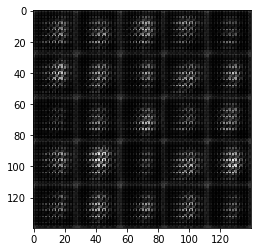

epoch 1 / 2 	 batch 110 / ? 	 generator loss: 2.361243486404419 	 discriminator loss: 0.5782942771911621
epoch 1 / 2 	 batch 120 / ? 	 generator loss: 2.2801451683044434 	 discriminator loss: 0.5295307636260986
epoch 1 / 2 	 batch 130 / ? 	 generator loss: 2.616847276687622 	 discriminator loss: 0.6239317655563354
epoch 1 / 2 	 batch 140 / ? 	 generator loss: 1.0600438117980957 	 discriminator loss: 1.1552103757858276
epoch 1 / 2 	 batch 150 / ? 	 generator loss: 1.1775660514831543 	 discriminator loss: 1.0587005615234375
epoch 1 / 2 	 batch 160 / ? 	 generator loss: 1.3898577690124512 	 discriminator loss: 1.0678240060806274
epoch 1 / 2 	 batch 170 / ? 	 generator loss: 0.7455090880393982 	 discriminator loss: 1.3431609869003296
epoch 1 / 2 	 batch 180 / ? 	 generator loss: 1.423628330230713 	 discriminator loss: 1.0645787715911865
epoch 1 / 2 	 batch 190 / ? 	 generator loss: 1.1146341562271118 	 discriminator loss: 1.0939466953277588
epoch 1 / 2 	 batch 200 / ? 	 generator loss: 0.6

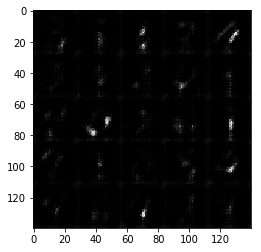

epoch 1 / 2 	 batch 210 / ? 	 generator loss: 0.8560338616371155 	 discriminator loss: 1.7908802032470703
epoch 1 / 2 	 batch 220 / ? 	 generator loss: 1.0209828615188599 	 discriminator loss: 1.1440953016281128
epoch 1 / 2 	 batch 230 / ? 	 generator loss: 1.2793911695480347 	 discriminator loss: 1.3675516843795776
epoch 1 / 2 	 batch 240 / ? 	 generator loss: 1.1191455125808716 	 discriminator loss: 1.2266614437103271
epoch 1 / 2 	 batch 250 / ? 	 generator loss: 0.7897070646286011 	 discriminator loss: 1.3180698156356812
epoch 1 / 2 	 batch 260 / ? 	 generator loss: 0.9362879991531372 	 discriminator loss: 1.2593200206756592
epoch 1 / 2 	 batch 270 / ? 	 generator loss: 0.909533679485321 	 discriminator loss: 1.1458051204681396
epoch 1 / 2 	 batch 280 / ? 	 generator loss: 0.944827139377594 	 discriminator loss: 1.225368857383728
epoch 1 / 2 	 batch 290 / ? 	 generator loss: 0.714212954044342 	 discriminator loss: 1.2742273807525635
epoch 1 / 2 	 batch 300 / ? 	 generator loss: 0.78

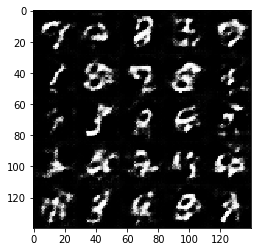

epoch 1 / 2 	 batch 310 / ? 	 generator loss: 0.7111539840698242 	 discriminator loss: 1.2704088687896729
epoch 1 / 2 	 batch 320 / ? 	 generator loss: 1.0713049173355103 	 discriminator loss: 1.184889793395996
epoch 1 / 2 	 batch 330 / ? 	 generator loss: 1.0579731464385986 	 discriminator loss: 1.1639821529388428
epoch 1 / 2 	 batch 340 / ? 	 generator loss: 0.6837872266769409 	 discriminator loss: 1.31858229637146
epoch 1 / 2 	 batch 350 / ? 	 generator loss: 0.8185373544692993 	 discriminator loss: 1.210904836654663
epoch 1 / 2 	 batch 360 / ? 	 generator loss: 1.2004454135894775 	 discriminator loss: 1.0659689903259277
epoch 1 / 2 	 batch 370 / ? 	 generator loss: 1.2420973777770996 	 discriminator loss: 1.2192885875701904
epoch 1 / 2 	 batch 380 / ? 	 generator loss: 0.6500846147537231 	 discriminator loss: 1.442704677581787
epoch 1 / 2 	 batch 390 / ? 	 generator loss: 0.7241913080215454 	 discriminator loss: 1.2950499057769775
epoch 1 / 2 	 batch 400 / ? 	 generator loss: 0.694

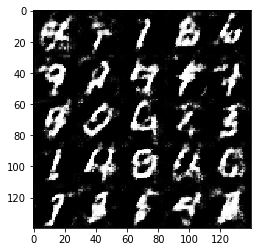

epoch 1 / 2 	 batch 410 / ? 	 generator loss: 0.8197996020317078 	 discriminator loss: 1.1978049278259277
epoch 1 / 2 	 batch 420 / ? 	 generator loss: 0.8052405714988708 	 discriminator loss: 1.106893539428711
epoch 1 / 2 	 batch 430 / ? 	 generator loss: 1.075958490371704 	 discriminator loss: 1.1993889808654785
epoch 1 / 2 	 batch 440 / ? 	 generator loss: 1.0435612201690674 	 discriminator loss: 1.228088140487671
epoch 1 / 2 	 batch 450 / ? 	 generator loss: 0.9243115782737732 	 discriminator loss: 1.18558931350708
epoch 1 / 2 	 batch 460 / ? 	 generator loss: 1.0770796537399292 	 discriminator loss: 1.1604554653167725
epoch 1 / 2 	 batch 470 / ? 	 generator loss: 1.216874122619629 	 discriminator loss: 1.2142261266708374
epoch 1 / 2 	 batch 480 / ? 	 generator loss: 1.291473388671875 	 discriminator loss: 1.2483789920806885
epoch 1 / 2 	 batch 490 / ? 	 generator loss: 0.9048696756362915 	 discriminator loss: 1.2105183601379395
epoch 1 / 2 	 batch 500 / ? 	 generator loss: 1.19425

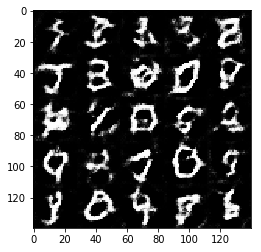

epoch 1 / 2 	 batch 510 / ? 	 generator loss: 1.064988136291504 	 discriminator loss: 1.2126538753509521
epoch 1 / 2 	 batch 520 / ? 	 generator loss: 0.6184484362602234 	 discriminator loss: 1.2889652252197266
epoch 1 / 2 	 batch 530 / ? 	 generator loss: 0.9698067307472229 	 discriminator loss: 1.1348379850387573
epoch 1 / 2 	 batch 540 / ? 	 generator loss: 0.5685005784034729 	 discriminator loss: 1.3911055326461792
epoch 1 / 2 	 batch 550 / ? 	 generator loss: 0.7160744667053223 	 discriminator loss: 1.2800421714782715
epoch 1 / 2 	 batch 560 / ? 	 generator loss: 1.123532772064209 	 discriminator loss: 1.1027450561523438
epoch 1 / 2 	 batch 570 / ? 	 generator loss: 0.7527343034744263 	 discriminator loss: 1.268643856048584
epoch 1 / 2 	 batch 580 / ? 	 generator loss: 1.2325944900512695 	 discriminator loss: 1.2507517337799072
epoch 1 / 2 	 batch 590 / ? 	 generator loss: 1.1502387523651123 	 discriminator loss: 1.1679518222808838
epoch 1 / 2 	 batch 600 / ? 	 generator loss: 0.9

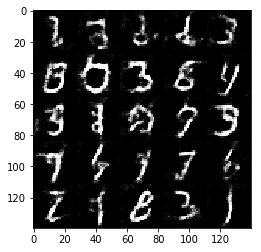

epoch 1 / 2 	 batch 610 / ? 	 generator loss: 0.8849225640296936 	 discriminator loss: 1.1934847831726074
epoch 1 / 2 	 batch 620 / ? 	 generator loss: 1.1182348728179932 	 discriminator loss: 1.193089246749878
epoch 1 / 2 	 batch 630 / ? 	 generator loss: 0.8821214437484741 	 discriminator loss: 1.230116367340088
epoch 1 / 2 	 batch 640 / ? 	 generator loss: 1.2608277797698975 	 discriminator loss: 1.2506730556488037
epoch 1 / 2 	 batch 650 / ? 	 generator loss: 1.184615969657898 	 discriminator loss: 1.2200450897216797
epoch 1 / 2 	 batch 660 / ? 	 generator loss: 1.184062123298645 	 discriminator loss: 1.2358157634735107
epoch 1 / 2 	 batch 670 / ? 	 generator loss: 0.7468105554580688 	 discriminator loss: 1.1580356359481812
epoch 1 / 2 	 batch 680 / ? 	 generator loss: 1.004481554031372 	 discriminator loss: 1.1996123790740967
epoch 1 / 2 	 batch 690 / ? 	 generator loss: 1.0703574419021606 	 discriminator loss: 1.124936819076538
epoch 1 / 2 	 batch 700 / ? 	 generator loss: 0.8636

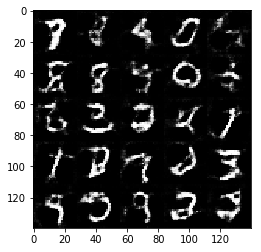

epoch 1 / 2 	 batch 710 / ? 	 generator loss: 1.3497123718261719 	 discriminator loss: 1.2743005752563477
epoch 1 / 2 	 batch 720 / ? 	 generator loss: 1.1682013273239136 	 discriminator loss: 1.123598337173462
epoch 1 / 2 	 batch 730 / ? 	 generator loss: 1.1758215427398682 	 discriminator loss: 1.274048089981079
epoch 1 / 2 	 batch 740 / ? 	 generator loss: 0.8655152320861816 	 discriminator loss: 1.1771392822265625
epoch 1 / 2 	 batch 750 / ? 	 generator loss: 1.0405768156051636 	 discriminator loss: 1.1127336025238037
epoch 1 / 2 	 batch 760 / ? 	 generator loss: 1.0260365009307861 	 discriminator loss: 1.17877197265625
epoch 1 / 2 	 batch 770 / ? 	 generator loss: 1.1915372610092163 	 discriminator loss: 1.207183599472046
epoch 1 / 2 	 batch 780 / ? 	 generator loss: 0.8463133573532104 	 discriminator loss: 1.2545385360717773
epoch 1 / 2 	 batch 790 / ? 	 generator loss: 0.9733704328536987 	 discriminator loss: 1.1656954288482666
epoch 1 / 2 	 batch 800 / ? 	 generator loss: 0.918

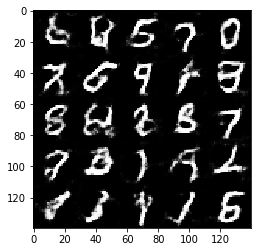

epoch 1 / 2 	 batch 810 / ? 	 generator loss: 0.5757938623428345 	 discriminator loss: 1.352747917175293
epoch 1 / 2 	 batch 820 / ? 	 generator loss: 0.7988373637199402 	 discriminator loss: 1.150151252746582
epoch 1 / 2 	 batch 830 / ? 	 generator loss: 1.2248506546020508 	 discriminator loss: 1.1545190811157227
epoch 1 / 2 	 batch 840 / ? 	 generator loss: 0.9366835355758667 	 discriminator loss: 1.20662260055542
epoch 1 / 2 	 batch 850 / ? 	 generator loss: 1.187145709991455 	 discriminator loss: 1.2376124858856201
epoch 1 / 2 	 batch 860 / ? 	 generator loss: 1.0439494848251343 	 discriminator loss: 1.1416524648666382
epoch 1 / 2 	 batch 870 / ? 	 generator loss: 0.8116865754127502 	 discriminator loss: 1.2552268505096436
epoch 1 / 2 	 batch 880 / ? 	 generator loss: 1.0816371440887451 	 discriminator loss: 1.177619457244873
epoch 1 / 2 	 batch 890 / ? 	 generator loss: 1.265652060508728 	 discriminator loss: 1.2395946979522705
epoch 1 / 2 	 batch 900 / ? 	 generator loss: 0.82118

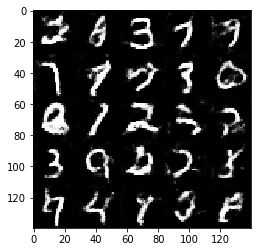

epoch 1 / 2 	 batch 910 / ? 	 generator loss: 1.4082863330841064 	 discriminator loss: 1.1232516765594482
epoch 1 / 2 	 batch 920 / ? 	 generator loss: 0.7642853260040283 	 discriminator loss: 1.2372660636901855
epoch 1 / 2 	 batch 930 / ? 	 generator loss: 0.5290375351905823 	 discriminator loss: 1.4186933040618896
epoch 2 / 2 	 batch 0 / ? 	 generator loss: 0.75465989112854 	 discriminator loss: 1.2484506368637085


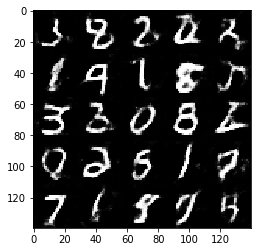

epoch 2 / 2 	 batch 10 / ? 	 generator loss: 0.9907772541046143 	 discriminator loss: 1.1263521909713745
epoch 2 / 2 	 batch 20 / ? 	 generator loss: 1.1507618427276611 	 discriminator loss: 1.2285456657409668
epoch 2 / 2 	 batch 30 / ? 	 generator loss: 1.1040942668914795 	 discriminator loss: 1.1985101699829102
epoch 2 / 2 	 batch 40 / ? 	 generator loss: 0.9317140579223633 	 discriminator loss: 1.1798694133758545
epoch 2 / 2 	 batch 50 / ? 	 generator loss: 0.7248059511184692 	 discriminator loss: 1.266717791557312
epoch 2 / 2 	 batch 60 / ? 	 generator loss: 0.9347615242004395 	 discriminator loss: 1.184039831161499
epoch 2 / 2 	 batch 70 / ? 	 generator loss: 0.7970382571220398 	 discriminator loss: 1.2400529384613037
epoch 2 / 2 	 batch 80 / ? 	 generator loss: 1.0732860565185547 	 discriminator loss: 1.1547439098358154
epoch 2 / 2 	 batch 90 / ? 	 generator loss: 1.21763277053833 	 discriminator loss: 1.135106086730957
epoch 2 / 2 	 batch 100 / ? 	 generator loss: 0.891889810562

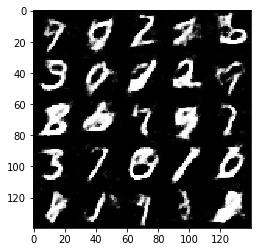

epoch 2 / 2 	 batch 110 / ? 	 generator loss: 0.7775935530662537 	 discriminator loss: 1.2531962394714355
epoch 2 / 2 	 batch 120 / ? 	 generator loss: 1.2438390254974365 	 discriminator loss: 1.1141109466552734
epoch 2 / 2 	 batch 130 / ? 	 generator loss: 1.526104211807251 	 discriminator loss: 1.3448925018310547
epoch 2 / 2 	 batch 140 / ? 	 generator loss: 0.9189959168434143 	 discriminator loss: 1.2185204029083252
epoch 2 / 2 	 batch 150 / ? 	 generator loss: 1.0683870315551758 	 discriminator loss: 1.3056857585906982
epoch 2 / 2 	 batch 160 / ? 	 generator loss: 1.0035887956619263 	 discriminator loss: 1.1007931232452393
epoch 2 / 2 	 batch 170 / ? 	 generator loss: 1.4056460857391357 	 discriminator loss: 1.1084266901016235
epoch 2 / 2 	 batch 180 / ? 	 generator loss: 0.911105751991272 	 discriminator loss: 1.1597181558609009
epoch 2 / 2 	 batch 190 / ? 	 generator loss: 0.6875656843185425 	 discriminator loss: 1.2431182861328125
epoch 2 / 2 	 batch 200 / ? 	 generator loss: 0.

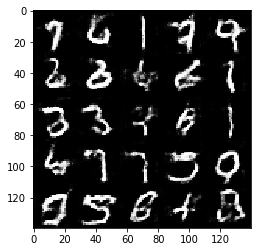

epoch 2 / 2 	 batch 210 / ? 	 generator loss: 0.8806509971618652 	 discriminator loss: 1.2214380502700806
epoch 2 / 2 	 batch 220 / ? 	 generator loss: 0.9568737745285034 	 discriminator loss: 1.2292537689208984
epoch 2 / 2 	 batch 230 / ? 	 generator loss: 0.8853383660316467 	 discriminator loss: 1.2308814525604248
epoch 2 / 2 	 batch 240 / ? 	 generator loss: 0.8593795895576477 	 discriminator loss: 1.2199711799621582
epoch 2 / 2 	 batch 250 / ? 	 generator loss: 0.7042195796966553 	 discriminator loss: 1.2825264930725098
epoch 2 / 2 	 batch 260 / ? 	 generator loss: 1.2283506393432617 	 discriminator loss: 1.1696444749832153
epoch 2 / 2 	 batch 270 / ? 	 generator loss: 0.9716258645057678 	 discriminator loss: 1.1498407125473022
epoch 2 / 2 	 batch 280 / ? 	 generator loss: 0.76986163854599 	 discriminator loss: 1.279396653175354
epoch 2 / 2 	 batch 290 / ? 	 generator loss: 0.8725383281707764 	 discriminator loss: 1.1562292575836182
epoch 2 / 2 	 batch 300 / ? 	 generator loss: 0.8

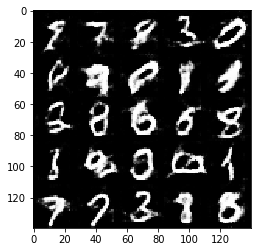

epoch 2 / 2 	 batch 310 / ? 	 generator loss: 0.9915795922279358 	 discriminator loss: 1.148911952972412
epoch 2 / 2 	 batch 320 / ? 	 generator loss: 1.149627923965454 	 discriminator loss: 1.1548707485198975
epoch 2 / 2 	 batch 330 / ? 	 generator loss: 1.1174290180206299 	 discriminator loss: 1.1813939809799194
epoch 2 / 2 	 batch 340 / ? 	 generator loss: 1.0753722190856934 	 discriminator loss: 1.288864016532898
epoch 2 / 2 	 batch 350 / ? 	 generator loss: 0.7590924501419067 	 discriminator loss: 1.2865121364593506
epoch 2 / 2 	 batch 360 / ? 	 generator loss: 1.0982277393341064 	 discriminator loss: 1.1237168312072754
epoch 2 / 2 	 batch 370 / ? 	 generator loss: 1.163773536682129 	 discriminator loss: 1.1516162157058716
epoch 2 / 2 	 batch 380 / ? 	 generator loss: 0.5978473424911499 	 discriminator loss: 1.3273980617523193
epoch 2 / 2 	 batch 390 / ? 	 generator loss: 0.7218852043151855 	 discriminator loss: 1.30476975440979
epoch 2 / 2 	 batch 400 / ? 	 generator loss: 0.8988

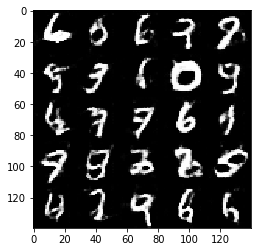

epoch 2 / 2 	 batch 410 / ? 	 generator loss: 1.230177879333496 	 discriminator loss: 1.193941593170166
epoch 2 / 2 	 batch 420 / ? 	 generator loss: 0.6903477907180786 	 discriminator loss: 1.271435260772705
epoch 2 / 2 	 batch 430 / ? 	 generator loss: 0.7504443526268005 	 discriminator loss: 1.2184090614318848
epoch 2 / 2 	 batch 440 / ? 	 generator loss: 1.0149332284927368 	 discriminator loss: 1.2379286289215088
epoch 2 / 2 	 batch 450 / ? 	 generator loss: 0.952255368232727 	 discriminator loss: 1.121534824371338
epoch 2 / 2 	 batch 460 / ? 	 generator loss: 1.1091445684432983 	 discriminator loss: 1.2322540283203125
epoch 2 / 2 	 batch 470 / ? 	 generator loss: 0.6417217254638672 	 discriminator loss: 1.2512001991271973
epoch 2 / 2 	 batch 480 / ? 	 generator loss: 1.0666412115097046 	 discriminator loss: 1.093665599822998
epoch 2 / 2 	 batch 490 / ? 	 generator loss: 1.0024782419204712 	 discriminator loss: 1.1172066926956177
epoch 2 / 2 	 batch 500 / ? 	 generator loss: 0.8577

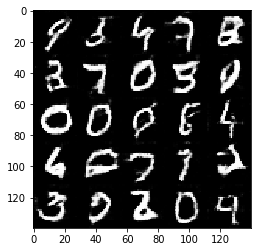

epoch 2 / 2 	 batch 510 / ? 	 generator loss: 1.0827882289886475 	 discriminator loss: 1.140307903289795
epoch 2 / 2 	 batch 520 / ? 	 generator loss: 0.7465396523475647 	 discriminator loss: 1.1586289405822754
epoch 2 / 2 	 batch 530 / ? 	 generator loss: 1.3865489959716797 	 discriminator loss: 1.1915628910064697
epoch 2 / 2 	 batch 540 / ? 	 generator loss: 0.9044045209884644 	 discriminator loss: 1.223357915878296
epoch 2 / 2 	 batch 550 / ? 	 generator loss: 0.6891312599182129 	 discriminator loss: 1.2617323398590088
epoch 2 / 2 	 batch 560 / ? 	 generator loss: 0.8390731811523438 	 discriminator loss: 1.2197213172912598
epoch 2 / 2 	 batch 570 / ? 	 generator loss: 0.9434916973114014 	 discriminator loss: 1.1314091682434082
epoch 2 / 2 	 batch 580 / ? 	 generator loss: 0.786280632019043 	 discriminator loss: 1.2685049772262573
epoch 2 / 2 	 batch 590 / ? 	 generator loss: 0.9029554128646851 	 discriminator loss: 1.1727157831192017
epoch 2 / 2 	 batch 600 / ? 	 generator loss: 0.3

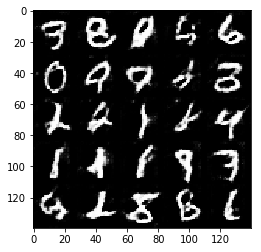

epoch 2 / 2 	 batch 610 / ? 	 generator loss: 0.859382688999176 	 discriminator loss: 1.1942040920257568
epoch 2 / 2 	 batch 620 / ? 	 generator loss: 0.8203030824661255 	 discriminator loss: 1.2022249698638916
epoch 2 / 2 	 batch 630 / ? 	 generator loss: 0.7558047771453857 	 discriminator loss: 1.2336981296539307
epoch 2 / 2 	 batch 640 / ? 	 generator loss: 1.116294026374817 	 discriminator loss: 1.1869728565216064
epoch 2 / 2 	 batch 650 / ? 	 generator loss: 1.286086082458496 	 discriminator loss: 1.113049030303955
epoch 2 / 2 	 batch 660 / ? 	 generator loss: 1.3498547077178955 	 discriminator loss: 0.9780913591384888
epoch 2 / 2 	 batch 670 / ? 	 generator loss: 1.0366511344909668 	 discriminator loss: 1.23763906955719
epoch 2 / 2 	 batch 680 / ? 	 generator loss: 0.5623269081115723 	 discriminator loss: 1.3642864227294922
epoch 2 / 2 	 batch 690 / ? 	 generator loss: 1.252570390701294 	 discriminator loss: 1.161975622177124
epoch 2 / 2 	 batch 700 / ? 	 generator loss: 1.127973

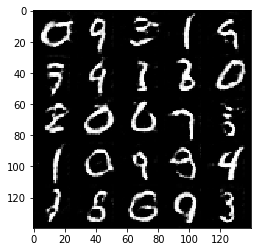

epoch 2 / 2 	 batch 710 / ? 	 generator loss: 0.6862297654151917 	 discriminator loss: 1.2706382274627686
epoch 2 / 2 	 batch 720 / ? 	 generator loss: 0.595833420753479 	 discriminator loss: 1.2882025241851807
epoch 2 / 2 	 batch 730 / ? 	 generator loss: 0.9528331756591797 	 discriminator loss: 1.1971890926361084
epoch 2 / 2 	 batch 740 / ? 	 generator loss: 0.9370470643043518 	 discriminator loss: 1.1227130889892578
epoch 2 / 2 	 batch 750 / ? 	 generator loss: 1.0963155031204224 	 discriminator loss: 1.1066128015518188
epoch 2 / 2 	 batch 760 / ? 	 generator loss: 0.8140302896499634 	 discriminator loss: 1.302193522453308
epoch 2 / 2 	 batch 770 / ? 	 generator loss: 0.9221735596656799 	 discriminator loss: 1.0616391897201538
epoch 2 / 2 	 batch 780 / ? 	 generator loss: 0.9174389839172363 	 discriminator loss: 1.1268138885498047
epoch 2 / 2 	 batch 790 / ? 	 generator loss: 0.9751286506652832 	 discriminator loss: 1.2156270742416382
epoch 2 / 2 	 batch 800 / ? 	 generator loss: 1.

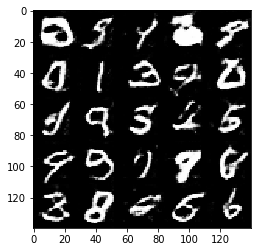

epoch 2 / 2 	 batch 810 / ? 	 generator loss: 0.7907099723815918 	 discriminator loss: 1.205761194229126
epoch 2 / 2 	 batch 820 / ? 	 generator loss: 0.739380955696106 	 discriminator loss: 1.1434391736984253
epoch 2 / 2 	 batch 830 / ? 	 generator loss: 0.7482991814613342 	 discriminator loss: 1.1679283380508423
epoch 2 / 2 	 batch 840 / ? 	 generator loss: 1.2646267414093018 	 discriminator loss: 1.1998672485351562
epoch 2 / 2 	 batch 850 / ? 	 generator loss: 1.7901489734649658 	 discriminator loss: 1.6552406549453735
epoch 2 / 2 	 batch 860 / ? 	 generator loss: 0.8832359313964844 	 discriminator loss: 1.081277847290039
epoch 2 / 2 	 batch 870 / ? 	 generator loss: 0.927828848361969 	 discriminator loss: 1.1198782920837402
epoch 2 / 2 	 batch 880 / ? 	 generator loss: 0.5339871048927307 	 discriminator loss: 1.351224660873413
epoch 2 / 2 	 batch 890 / ? 	 generator loss: 0.8788233995437622 	 discriminator loss: 1.1029078960418701
epoch 2 / 2 	 batch 900 / ? 	 generator loss: 0.899

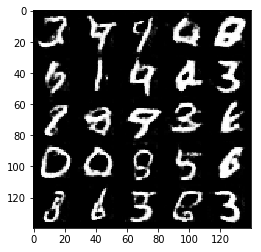

epoch 2 / 2 	 batch 910 / ? 	 generator loss: 1.498835563659668 	 discriminator loss: 1.1697006225585938
epoch 2 / 2 	 batch 920 / ? 	 generator loss: 0.9950731992721558 	 discriminator loss: 1.1457242965698242
epoch 2 / 2 	 batch 930 / ? 	 generator loss: 0.6741985082626343 	 discriminator loss: 1.3290234804153442


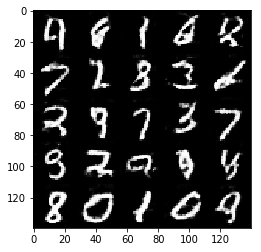

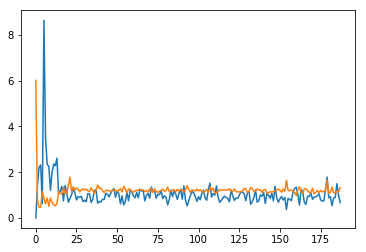

In [14]:
batch_size = 64
z_dim = 100
learning_rate = .00015
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1 / 1 	 batch 0 / ? 	 generator loss: 0.010121036320924759 	 discriminator loss: 5.264085292816162


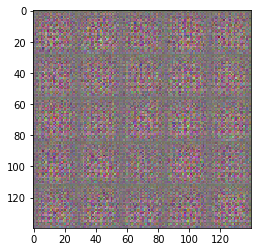

epoch 1 / 1 	 batch 10 / ? 	 generator loss: 0.24696879088878632 	 discriminator loss: 2.3706657886505127
epoch 1 / 1 	 batch 20 / ? 	 generator loss: 1.4083349704742432 	 discriminator loss: 1.13816499710083
epoch 1 / 1 	 batch 30 / ? 	 generator loss: 1.6084845066070557 	 discriminator loss: 0.8461954593658447
epoch 1 / 1 	 batch 40 / ? 	 generator loss: 1.0110664367675781 	 discriminator loss: 0.8868310451507568
epoch 1 / 1 	 batch 50 / ? 	 generator loss: 1.5057165622711182 	 discriminator loss: 0.8052025437355042
epoch 1 / 1 	 batch 60 / ? 	 generator loss: 1.3937400579452515 	 discriminator loss: 0.8033245801925659
epoch 1 / 1 	 batch 70 / ? 	 generator loss: 1.812172770500183 	 discriminator loss: 0.7846492528915405
epoch 1 / 1 	 batch 80 / ? 	 generator loss: 1.755696415901184 	 discriminator loss: 0.8639811873435974
epoch 1 / 1 	 batch 90 / ? 	 generator loss: 2.771847724914551 	 discriminator loss: 0.5548400282859802
epoch 1 / 1 	 batch 100 / ? 	 generator loss: 1.61166858673

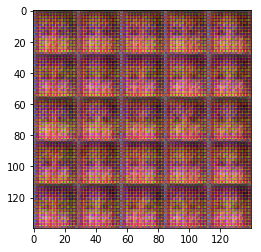

epoch 1 / 1 	 batch 110 / ? 	 generator loss: 2.1681156158447266 	 discriminator loss: 0.7874547243118286
epoch 1 / 1 	 batch 120 / ? 	 generator loss: 2.3901431560516357 	 discriminator loss: 0.6504462957382202
epoch 1 / 1 	 batch 130 / ? 	 generator loss: 1.3712276220321655 	 discriminator loss: 0.8225201368331909
epoch 1 / 1 	 batch 140 / ? 	 generator loss: 1.494417667388916 	 discriminator loss: 0.9767928719520569
epoch 1 / 1 	 batch 150 / ? 	 generator loss: 1.29896080493927 	 discriminator loss: 0.9913618564605713
epoch 1 / 1 	 batch 160 / ? 	 generator loss: 1.7560049295425415 	 discriminator loss: 0.8974872827529907
epoch 1 / 1 	 batch 170 / ? 	 generator loss: 0.7356613278388977 	 discriminator loss: 1.1862105131149292
epoch 1 / 1 	 batch 180 / ? 	 generator loss: 1.1113450527191162 	 discriminator loss: 1.01133131980896
epoch 1 / 1 	 batch 190 / ? 	 generator loss: 1.1311230659484863 	 discriminator loss: 0.9307333827018738
epoch 1 / 1 	 batch 200 / ? 	 generator loss: 0.360

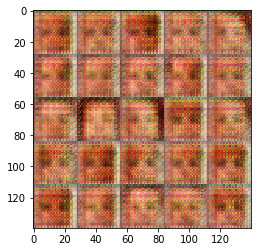

epoch 1 / 1 	 batch 210 / ? 	 generator loss: 1.4829227924346924 	 discriminator loss: 0.9689358472824097
epoch 1 / 1 	 batch 220 / ? 	 generator loss: 1.1787387132644653 	 discriminator loss: 1.1950535774230957
epoch 1 / 1 	 batch 230 / ? 	 generator loss: 1.2880265712738037 	 discriminator loss: 1.167954444885254
epoch 1 / 1 	 batch 240 / ? 	 generator loss: 1.7961485385894775 	 discriminator loss: 1.1367889642715454
epoch 1 / 1 	 batch 250 / ? 	 generator loss: 1.4326648712158203 	 discriminator loss: 0.950156569480896
epoch 1 / 1 	 batch 260 / ? 	 generator loss: 2.298915147781372 	 discriminator loss: 1.2729779481887817
epoch 1 / 1 	 batch 270 / ? 	 generator loss: 1.2214101552963257 	 discriminator loss: 1.1600532531738281
epoch 1 / 1 	 batch 280 / ? 	 generator loss: 1.1153533458709717 	 discriminator loss: 1.1364173889160156
epoch 1 / 1 	 batch 290 / ? 	 generator loss: 2.0285544395446777 	 discriminator loss: 0.8643573522567749
epoch 1 / 1 	 batch 300 / ? 	 generator loss: 1.3

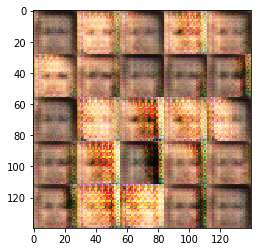

epoch 1 / 1 	 batch 310 / ? 	 generator loss: 1.0794389247894287 	 discriminator loss: 1.036176085472107
epoch 1 / 1 	 batch 320 / ? 	 generator loss: 0.6042372584342957 	 discriminator loss: 1.3928418159484863
epoch 1 / 1 	 batch 330 / ? 	 generator loss: 1.0721197128295898 	 discriminator loss: 1.1896710395812988
epoch 1 / 1 	 batch 340 / ? 	 generator loss: 1.326169729232788 	 discriminator loss: 1.017289638519287
epoch 1 / 1 	 batch 350 / ? 	 generator loss: 0.8751624822616577 	 discriminator loss: 1.4282689094543457
epoch 1 / 1 	 batch 360 / ? 	 generator loss: 1.6839138269424438 	 discriminator loss: 1.0364813804626465
epoch 1 / 1 	 batch 370 / ? 	 generator loss: 1.2244348526000977 	 discriminator loss: 0.9933508634567261
epoch 1 / 1 	 batch 380 / ? 	 generator loss: 1.0679640769958496 	 discriminator loss: 1.0168143510818481
epoch 1 / 1 	 batch 390 / ? 	 generator loss: 1.3273450136184692 	 discriminator loss: 1.0624641180038452
epoch 1 / 1 	 batch 400 / ? 	 generator loss: 1.4

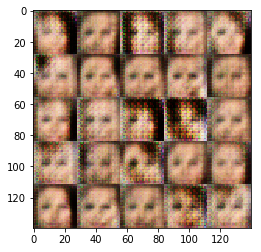

epoch 1 / 1 	 batch 410 / ? 	 generator loss: 1.1810429096221924 	 discriminator loss: 1.1076433658599854
epoch 1 / 1 	 batch 420 / ? 	 generator loss: 1.1254546642303467 	 discriminator loss: 1.217466115951538
epoch 1 / 1 	 batch 430 / ? 	 generator loss: 1.4112193584442139 	 discriminator loss: 1.0081865787506104
epoch 1 / 1 	 batch 440 / ? 	 generator loss: 0.8498969078063965 	 discriminator loss: 1.1762490272521973
epoch 1 / 1 	 batch 450 / ? 	 generator loss: 1.0659205913543701 	 discriminator loss: 1.217911720275879
epoch 1 / 1 	 batch 460 / ? 	 generator loss: 1.8546640872955322 	 discriminator loss: 0.7941782474517822
epoch 1 / 1 	 batch 470 / ? 	 generator loss: 1.5001654624938965 	 discriminator loss: 1.0952534675598145
epoch 1 / 1 	 batch 480 / ? 	 generator loss: 0.6582914590835571 	 discriminator loss: 1.4361910820007324
epoch 1 / 1 	 batch 490 / ? 	 generator loss: 0.9721997380256653 	 discriminator loss: 1.146643877029419
epoch 1 / 1 	 batch 500 / ? 	 generator loss: 1.2

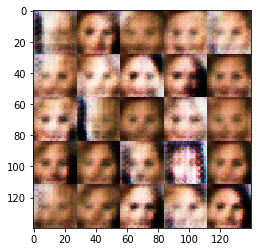

epoch 1 / 1 	 batch 510 / ? 	 generator loss: 1.047273874282837 	 discriminator loss: 1.0385236740112305
epoch 1 / 1 	 batch 520 / ? 	 generator loss: 1.0757379531860352 	 discriminator loss: 1.246991515159607
epoch 1 / 1 	 batch 530 / ? 	 generator loss: 1.0479342937469482 	 discriminator loss: 1.0259814262390137
epoch 1 / 1 	 batch 540 / ? 	 generator loss: 1.157564640045166 	 discriminator loss: 1.0572524070739746
epoch 1 / 1 	 batch 550 / ? 	 generator loss: 1.3849234580993652 	 discriminator loss: 0.9502878785133362
epoch 1 / 1 	 batch 560 / ? 	 generator loss: 1.5564427375793457 	 discriminator loss: 0.9744454622268677
epoch 1 / 1 	 batch 570 / ? 	 generator loss: 1.1878833770751953 	 discriminator loss: 0.905146062374115
epoch 1 / 1 	 batch 580 / ? 	 generator loss: 1.4490368366241455 	 discriminator loss: 1.0889064073562622
epoch 1 / 1 	 batch 590 / ? 	 generator loss: 2.416203498840332 	 discriminator loss: 1.427339792251587
epoch 1 / 1 	 batch 600 / ? 	 generator loss: 2.2647

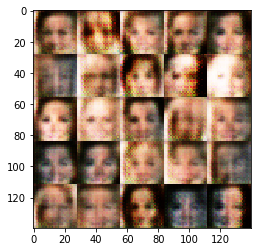

epoch 1 / 1 	 batch 610 / ? 	 generator loss: 0.9554922580718994 	 discriminator loss: 1.1004457473754883
epoch 1 / 1 	 batch 620 / ? 	 generator loss: 0.9603618383407593 	 discriminator loss: 1.2250274419784546
epoch 1 / 1 	 batch 630 / ? 	 generator loss: 1.0181517601013184 	 discriminator loss: 0.9333509802818298
epoch 1 / 1 	 batch 640 / ? 	 generator loss: 2.581287384033203 	 discriminator loss: 1.3227447271347046
epoch 1 / 1 	 batch 650 / ? 	 generator loss: 1.1561851501464844 	 discriminator loss: 0.9839416742324829
epoch 1 / 1 	 batch 660 / ? 	 generator loss: 1.3437448740005493 	 discriminator loss: 0.8293989300727844
epoch 1 / 1 	 batch 670 / ? 	 generator loss: 1.243019938468933 	 discriminator loss: 0.9298697710037231
epoch 1 / 1 	 batch 680 / ? 	 generator loss: 2.1125667095184326 	 discriminator loss: 0.8871282339096069
epoch 1 / 1 	 batch 690 / ? 	 generator loss: 1.2236974239349365 	 discriminator loss: 0.9047565460205078
epoch 1 / 1 	 batch 700 / ? 	 generator loss: 1.

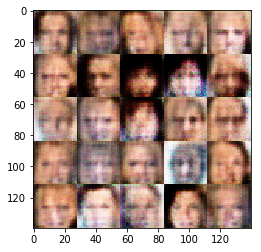

epoch 1 / 1 	 batch 710 / ? 	 generator loss: 0.44158387184143066 	 discriminator loss: 1.5340601205825806
epoch 1 / 1 	 batch 720 / ? 	 generator loss: 1.7808973789215088 	 discriminator loss: 0.833958625793457
epoch 1 / 1 	 batch 730 / ? 	 generator loss: 1.2563180923461914 	 discriminator loss: 0.9524076581001282
epoch 1 / 1 	 batch 740 / ? 	 generator loss: 0.739497184753418 	 discriminator loss: 1.2354730367660522
epoch 1 / 1 	 batch 750 / ? 	 generator loss: 0.6097776293754578 	 discriminator loss: 1.2863314151763916
epoch 1 / 1 	 batch 760 / ? 	 generator loss: 0.8258122205734253 	 discriminator loss: 1.0832818746566772
epoch 1 / 1 	 batch 770 / ? 	 generator loss: 0.5782202482223511 	 discriminator loss: 1.329551339149475
epoch 1 / 1 	 batch 780 / ? 	 generator loss: 0.9158844947814941 	 discriminator loss: 1.0729598999023438
epoch 1 / 1 	 batch 790 / ? 	 generator loss: 0.8119134306907654 	 discriminator loss: 1.1569039821624756
epoch 1 / 1 	 batch 800 / ? 	 generator loss: 2.

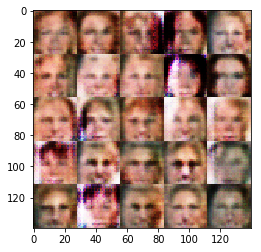

epoch 1 / 1 	 batch 810 / ? 	 generator loss: 1.5489577054977417 	 discriminator loss: 0.7689767479896545
epoch 1 / 1 	 batch 820 / ? 	 generator loss: 0.7781431674957275 	 discriminator loss: 1.1302361488342285
epoch 1 / 1 	 batch 830 / ? 	 generator loss: 2.394345283508301 	 discriminator loss: 1.3664166927337646
epoch 1 / 1 	 batch 840 / ? 	 generator loss: 1.8838447332382202 	 discriminator loss: 1.3274251222610474
epoch 1 / 1 	 batch 850 / ? 	 generator loss: 1.2402764558792114 	 discriminator loss: 0.8069067001342773
epoch 1 / 1 	 batch 860 / ? 	 generator loss: 1.7497403621673584 	 discriminator loss: 0.7541090846061707
epoch 1 / 1 	 batch 870 / ? 	 generator loss: 1.682602047920227 	 discriminator loss: 1.1970458030700684
epoch 1 / 1 	 batch 880 / ? 	 generator loss: 0.919119119644165 	 discriminator loss: 1.0365949869155884
epoch 1 / 1 	 batch 890 / ? 	 generator loss: 1.307060718536377 	 discriminator loss: 1.1108875274658203
epoch 1 / 1 	 batch 900 / ? 	 generator loss: 0.92

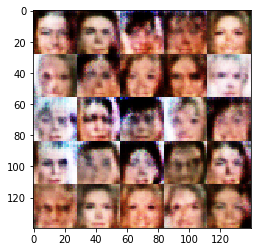

epoch 1 / 1 	 batch 910 / ? 	 generator loss: 1.568057894706726 	 discriminator loss: 0.7976976037025452
epoch 1 / 1 	 batch 920 / ? 	 generator loss: 2.4952831268310547 	 discriminator loss: 0.6431660652160645
epoch 1 / 1 	 batch 930 / ? 	 generator loss: 2.88824462890625 	 discriminator loss: 1.1531953811645508
epoch 1 / 1 	 batch 940 / ? 	 generator loss: 1.2960082292556763 	 discriminator loss: 0.8608585596084595
epoch 1 / 1 	 batch 950 / ? 	 generator loss: 0.7491371631622314 	 discriminator loss: 1.4450268745422363
epoch 1 / 1 	 batch 960 / ? 	 generator loss: 2.180943727493286 	 discriminator loss: 1.2088072299957275
epoch 1 / 1 	 batch 970 / ? 	 generator loss: 1.4308137893676758 	 discriminator loss: 0.8247056603431702
epoch 1 / 1 	 batch 980 / ? 	 generator loss: 1.4429614543914795 	 discriminator loss: 1.0566432476043701
epoch 1 / 1 	 batch 990 / ? 	 generator loss: 1.7473164796829224 	 discriminator loss: 1.4943076372146606
epoch 1 / 1 	 batch 1000 / ? 	 generator loss: 1.1

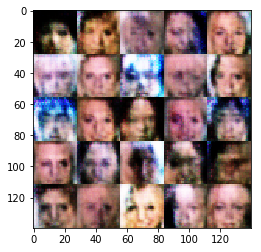

epoch 1 / 1 	 batch 1010 / ? 	 generator loss: 2.832517623901367 	 discriminator loss: 0.7203093767166138
epoch 1 / 1 	 batch 1020 / ? 	 generator loss: 2.405015468597412 	 discriminator loss: 0.6289840936660767
epoch 1 / 1 	 batch 1030 / ? 	 generator loss: 0.9038662910461426 	 discriminator loss: 1.0988073348999023
epoch 1 / 1 	 batch 1040 / ? 	 generator loss: 2.153812885284424 	 discriminator loss: 0.6555294990539551
epoch 1 / 1 	 batch 1050 / ? 	 generator loss: 0.5270352959632874 	 discriminator loss: 1.523430585861206
epoch 1 / 1 	 batch 1060 / ? 	 generator loss: 1.6132848262786865 	 discriminator loss: 0.7922891974449158
epoch 1 / 1 	 batch 1070 / ? 	 generator loss: 2.58669376373291 	 discriminator loss: 0.7414308786392212
epoch 1 / 1 	 batch 1080 / ? 	 generator loss: 2.668241262435913 	 discriminator loss: 0.7715211510658264
epoch 1 / 1 	 batch 1090 / ? 	 generator loss: 1.5456364154815674 	 discriminator loss: 0.8062882423400879
epoch 1 / 1 	 batch 1100 / ? 	 generator los

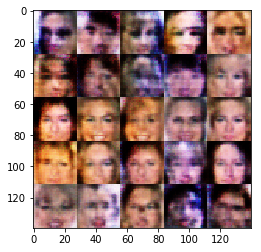

epoch 1 / 1 	 batch 1110 / ? 	 generator loss: 1.342795729637146 	 discriminator loss: 0.9005061984062195
epoch 1 / 1 	 batch 1120 / ? 	 generator loss: 1.3921746015548706 	 discriminator loss: 0.7590706944465637
epoch 1 / 1 	 batch 1130 / ? 	 generator loss: 1.096097707748413 	 discriminator loss: 1.0524671077728271
epoch 1 / 1 	 batch 1140 / ? 	 generator loss: 0.9611797332763672 	 discriminator loss: 0.9946815371513367
epoch 1 / 1 	 batch 1150 / ? 	 generator loss: 0.8030899167060852 	 discriminator loss: 1.0718326568603516
epoch 1 / 1 	 batch 1160 / ? 	 generator loss: 1.6245832443237305 	 discriminator loss: 0.7524889707565308
epoch 1 / 1 	 batch 1170 / ? 	 generator loss: 1.6939163208007812 	 discriminator loss: 1.63112473487854
epoch 1 / 1 	 batch 1180 / ? 	 generator loss: 1.819079875946045 	 discriminator loss: 1.2419278621673584
epoch 1 / 1 	 batch 1190 / ? 	 generator loss: 0.9198042154312134 	 discriminator loss: 0.9915217161178589
epoch 1 / 1 	 batch 1200 / ? 	 generator l

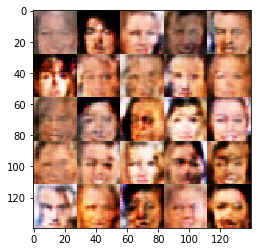

epoch 1 / 1 	 batch 1210 / ? 	 generator loss: 0.8948725461959839 	 discriminator loss: 1.0642931461334229
epoch 1 / 1 	 batch 1220 / ? 	 generator loss: 2.3992323875427246 	 discriminator loss: 0.6991977095603943
epoch 1 / 1 	 batch 1230 / ? 	 generator loss: 0.5155602097511292 	 discriminator loss: 1.4076645374298096
epoch 1 / 1 	 batch 1240 / ? 	 generator loss: 0.8998638391494751 	 discriminator loss: 1.142932653427124
epoch 1 / 1 	 batch 1250 / ? 	 generator loss: 2.431995391845703 	 discriminator loss: 0.793195366859436
epoch 1 / 1 	 batch 1260 / ? 	 generator loss: 1.6336748600006104 	 discriminator loss: 0.9306632280349731
epoch 1 / 1 	 batch 1270 / ? 	 generator loss: 3.2645490169525146 	 discriminator loss: 0.623397707939148
epoch 1 / 1 	 batch 1280 / ? 	 generator loss: 0.9469216465950012 	 discriminator loss: 0.9174975156784058
epoch 1 / 1 	 batch 1290 / ? 	 generator loss: 1.0670440196990967 	 discriminator loss: 0.90582275390625
epoch 1 / 1 	 batch 1300 / ? 	 generator lo

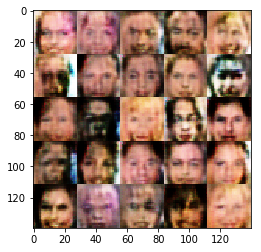

epoch 1 / 1 	 batch 1310 / ? 	 generator loss: 2.4704837799072266 	 discriminator loss: 1.342154622077942
epoch 1 / 1 	 batch 1320 / ? 	 generator loss: 0.9234098196029663 	 discriminator loss: 1.034307599067688
epoch 1 / 1 	 batch 1330 / ? 	 generator loss: 1.3592292070388794 	 discriminator loss: 1.1348028182983398
epoch 1 / 1 	 batch 1340 / ? 	 generator loss: 1.1470098495483398 	 discriminator loss: 0.9235488176345825
epoch 1 / 1 	 batch 1350 / ? 	 generator loss: 1.592502236366272 	 discriminator loss: 0.7648322582244873
epoch 1 / 1 	 batch 1360 / ? 	 generator loss: 1.398005485534668 	 discriminator loss: 0.7612820863723755
epoch 1 / 1 	 batch 1370 / ? 	 generator loss: 0.965396523475647 	 discriminator loss: 0.9533126950263977
epoch 1 / 1 	 batch 1380 / ? 	 generator loss: 1.0346026420593262 	 discriminator loss: 0.9194972515106201
epoch 1 / 1 	 batch 1390 / ? 	 generator loss: 1.235155701637268 	 discriminator loss: 0.9065337181091309
epoch 1 / 1 	 batch 1400 / ? 	 generator lo

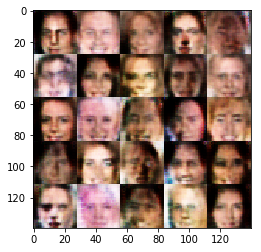

epoch 1 / 1 	 batch 1410 / ? 	 generator loss: 0.760479211807251 	 discriminator loss: 1.0949146747589111
epoch 1 / 1 	 batch 1420 / ? 	 generator loss: 1.8067697286605835 	 discriminator loss: 0.971260666847229
epoch 1 / 1 	 batch 1430 / ? 	 generator loss: 2.0198259353637695 	 discriminator loss: 0.671392023563385
epoch 1 / 1 	 batch 1440 / ? 	 generator loss: 1.2600836753845215 	 discriminator loss: 0.9602338075637817
epoch 1 / 1 	 batch 1450 / ? 	 generator loss: 1.910715103149414 	 discriminator loss: 0.7596245408058167
epoch 1 / 1 	 batch 1460 / ? 	 generator loss: 1.4213876724243164 	 discriminator loss: 0.968951404094696
epoch 1 / 1 	 batch 1470 / ? 	 generator loss: 0.817306399345398 	 discriminator loss: 1.1026016473770142
epoch 1 / 1 	 batch 1480 / ? 	 generator loss: 2.7588207721710205 	 discriminator loss: 0.8364239931106567
epoch 1 / 1 	 batch 1490 / ? 	 generator loss: 0.6815531253814697 	 discriminator loss: 1.2385997772216797
epoch 1 / 1 	 batch 1500 / ? 	 generator lo

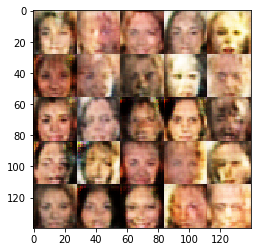

epoch 1 / 1 	 batch 1510 / ? 	 generator loss: 1.4628582000732422 	 discriminator loss: 0.7986360788345337
epoch 1 / 1 	 batch 1520 / ? 	 generator loss: 0.9466530680656433 	 discriminator loss: 1.0772020816802979
epoch 1 / 1 	 batch 1530 / ? 	 generator loss: 1.1046591997146606 	 discriminator loss: 1.169275164604187
epoch 1 / 1 	 batch 1540 / ? 	 generator loss: 1.5219755172729492 	 discriminator loss: 0.8077917098999023
epoch 1 / 1 	 batch 1550 / ? 	 generator loss: 0.8468900322914124 	 discriminator loss: 1.1187269687652588
epoch 1 / 1 	 batch 1560 / ? 	 generator loss: 0.936804473400116 	 discriminator loss: 1.2173042297363281
epoch 1 / 1 	 batch 1570 / ? 	 generator loss: 1.8330655097961426 	 discriminator loss: 0.693050742149353
epoch 1 / 1 	 batch 1580 / ? 	 generator loss: 0.6991060972213745 	 discriminator loss: 1.3188053369522095
epoch 1 / 1 	 batch 1590 / ? 	 generator loss: 1.8614925146102905 	 discriminator loss: 0.8296416997909546
epoch 1 / 1 	 batch 1600 / ? 	 generator

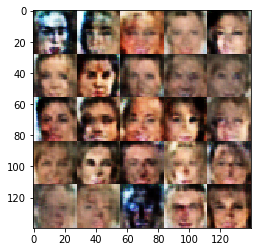

epoch 1 / 1 	 batch 1610 / ? 	 generator loss: 0.869646430015564 	 discriminator loss: 1.0943684577941895
epoch 1 / 1 	 batch 1620 / ? 	 generator loss: 1.4451344013214111 	 discriminator loss: 0.868408203125
epoch 1 / 1 	 batch 1630 / ? 	 generator loss: 3.404994487762451 	 discriminator loss: 0.6208956837654114
epoch 1 / 1 	 batch 1640 / ? 	 generator loss: 1.0016582012176514 	 discriminator loss: 0.9860547780990601
epoch 1 / 1 	 batch 1650 / ? 	 generator loss: 1.055983066558838 	 discriminator loss: 0.9637729525566101
epoch 1 / 1 	 batch 1660 / ? 	 generator loss: 1.3091644048690796 	 discriminator loss: 0.900212287902832
epoch 1 / 1 	 batch 1670 / ? 	 generator loss: 1.9609088897705078 	 discriminator loss: 0.7588760852813721
epoch 1 / 1 	 batch 1680 / ? 	 generator loss: 2.0590415000915527 	 discriminator loss: 1.025902509689331
epoch 1 / 1 	 batch 1690 / ? 	 generator loss: 1.5374594926834106 	 discriminator loss: 0.841819703578949
epoch 1 / 1 	 batch 1700 / ? 	 generator loss: 

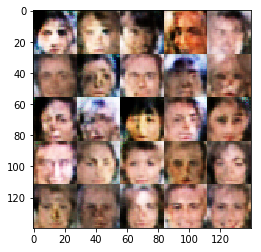

epoch 1 / 1 	 batch 1710 / ? 	 generator loss: 1.7708497047424316 	 discriminator loss: 0.7578718662261963
epoch 1 / 1 	 batch 1720 / ? 	 generator loss: 2.586632251739502 	 discriminator loss: 0.6350142359733582
epoch 1 / 1 	 batch 1730 / ? 	 generator loss: 1.8524351119995117 	 discriminator loss: 0.9542829990386963
epoch 1 / 1 	 batch 1740 / ? 	 generator loss: 2.629368305206299 	 discriminator loss: 0.6611748337745667
epoch 1 / 1 	 batch 1750 / ? 	 generator loss: 1.7422362565994263 	 discriminator loss: 0.8488636016845703
epoch 1 / 1 	 batch 1760 / ? 	 generator loss: 0.8046287298202515 	 discriminator loss: 1.114669680595398
epoch 1 / 1 	 batch 1770 / ? 	 generator loss: 1.2714300155639648 	 discriminator loss: 1.4245555400848389
epoch 1 / 1 	 batch 1780 / ? 	 generator loss: 1.3525184392929077 	 discriminator loss: 0.8448933959007263
epoch 1 / 1 	 batch 1790 / ? 	 generator loss: 2.0677051544189453 	 discriminator loss: 0.754625678062439
epoch 1 / 1 	 batch 1800 / ? 	 generator 

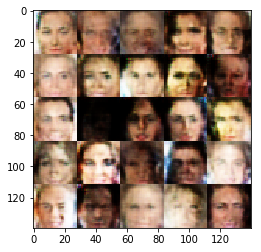

epoch 1 / 1 	 batch 1810 / ? 	 generator loss: 2.350999355316162 	 discriminator loss: 0.7680107355117798
epoch 1 / 1 	 batch 1820 / ? 	 generator loss: 1.5631287097930908 	 discriminator loss: 1.0549829006195068
epoch 1 / 1 	 batch 1830 / ? 	 generator loss: 1.0289535522460938 	 discriminator loss: 0.9834805727005005
epoch 1 / 1 	 batch 1840 / ? 	 generator loss: 0.858458399772644 	 discriminator loss: 1.1166036128997803
epoch 1 / 1 	 batch 1850 / ? 	 generator loss: 2.505449056625366 	 discriminator loss: 0.5942330956459045
epoch 1 / 1 	 batch 1860 / ? 	 generator loss: 1.4843199253082275 	 discriminator loss: 0.7063934803009033
epoch 1 / 1 	 batch 1870 / ? 	 generator loss: 2.2499289512634277 	 discriminator loss: 0.604178249835968
epoch 1 / 1 	 batch 1880 / ? 	 generator loss: 1.8429327011108398 	 discriminator loss: 0.7036734819412231
epoch 1 / 1 	 batch 1890 / ? 	 generator loss: 0.8946933150291443 	 discriminator loss: 1.0743722915649414
epoch 1 / 1 	 batch 1900 / ? 	 generator 

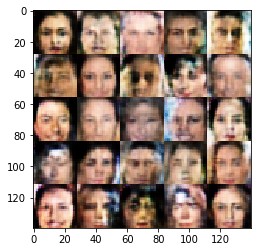

epoch 1 / 1 	 batch 1910 / ? 	 generator loss: 1.0302751064300537 	 discriminator loss: 0.9923876523971558
epoch 1 / 1 	 batch 1920 / ? 	 generator loss: 0.8959704637527466 	 discriminator loss: 1.0539100170135498
epoch 1 / 1 	 batch 1930 / ? 	 generator loss: 2.9863996505737305 	 discriminator loss: 0.6128755211830139
epoch 1 / 1 	 batch 1940 / ? 	 generator loss: 1.474907636642456 	 discriminator loss: 0.833081066608429
epoch 1 / 1 	 batch 1950 / ? 	 generator loss: 0.8752252459526062 	 discriminator loss: 1.001129388809204
epoch 1 / 1 	 batch 1960 / ? 	 generator loss: 1.3664562702178955 	 discriminator loss: 0.8708765506744385
epoch 1 / 1 	 batch 1970 / ? 	 generator loss: 1.738093614578247 	 discriminator loss: 0.8083522319793701
epoch 1 / 1 	 batch 1980 / ? 	 generator loss: 1.0489881038665771 	 discriminator loss: 0.9397112727165222
epoch 1 / 1 	 batch 1990 / ? 	 generator loss: 0.965731680393219 	 discriminator loss: 1.0771816968917847
epoch 1 / 1 	 batch 2000 / ? 	 generator l

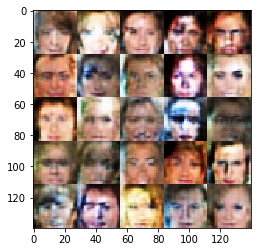

epoch 1 / 1 	 batch 2010 / ? 	 generator loss: 1.213308334350586 	 discriminator loss: 0.8121888637542725
epoch 1 / 1 	 batch 2020 / ? 	 generator loss: 2.269690990447998 	 discriminator loss: 0.7075469493865967
epoch 1 / 1 	 batch 2030 / ? 	 generator loss: 1.7045687437057495 	 discriminator loss: 0.7991043329238892
epoch 1 / 1 	 batch 2040 / ? 	 generator loss: 1.8461225032806396 	 discriminator loss: 0.7695345878601074
epoch 1 / 1 	 batch 2050 / ? 	 generator loss: 0.7633470296859741 	 discriminator loss: 1.091179609298706
epoch 1 / 1 	 batch 2060 / ? 	 generator loss: 1.3700883388519287 	 discriminator loss: 0.7541231513023376
epoch 1 / 1 	 batch 2070 / ? 	 generator loss: 1.280134677886963 	 discriminator loss: 0.8044146299362183
epoch 1 / 1 	 batch 2080 / ? 	 generator loss: 1.6687506437301636 	 discriminator loss: 0.7036008238792419
epoch 1 / 1 	 batch 2090 / ? 	 generator loss: 0.6045993566513062 	 discriminator loss: 1.3330583572387695
epoch 1 / 1 	 batch 2100 / ? 	 generator 

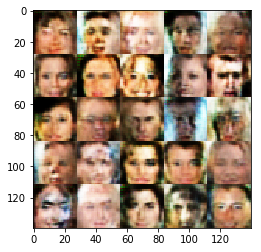

epoch 1 / 1 	 batch 2110 / ? 	 generator loss: 1.5531644821166992 	 discriminator loss: 0.8015521764755249
epoch 1 / 1 	 batch 2120 / ? 	 generator loss: 1.04775071144104 	 discriminator loss: 0.9292659163475037
epoch 1 / 1 	 batch 2130 / ? 	 generator loss: 1.3596082925796509 	 discriminator loss: 0.724716067314148
epoch 1 / 1 	 batch 2140 / ? 	 generator loss: 1.8472965955734253 	 discriminator loss: 0.7511419057846069
epoch 1 / 1 	 batch 2150 / ? 	 generator loss: 1.7944403886795044 	 discriminator loss: 0.6095548272132874
epoch 1 / 1 	 batch 2160 / ? 	 generator loss: 1.4895343780517578 	 discriminator loss: 0.7552692890167236
epoch 1 / 1 	 batch 2170 / ? 	 generator loss: 1.0287724733352661 	 discriminator loss: 0.9373226761817932
epoch 1 / 1 	 batch 2180 / ? 	 generator loss: 1.546276569366455 	 discriminator loss: 1.0751070976257324
epoch 1 / 1 	 batch 2190 / ? 	 generator loss: 1.0515120029449463 	 discriminator loss: 0.8943709135055542
epoch 1 / 1 	 batch 2200 / ? 	 generator 

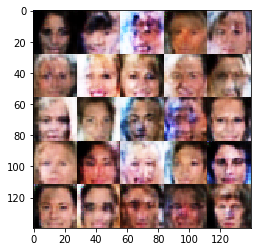

epoch 1 / 1 	 batch 2210 / ? 	 generator loss: 1.0219581127166748 	 discriminator loss: 0.9531934857368469
epoch 1 / 1 	 batch 2220 / ? 	 generator loss: 1.2865649461746216 	 discriminator loss: 0.836294412612915
epoch 1 / 1 	 batch 2230 / ? 	 generator loss: 0.423067182302475 	 discriminator loss: 1.614456295967102
epoch 1 / 1 	 batch 2240 / ? 	 generator loss: 1.6713635921478271 	 discriminator loss: 0.6563369035720825
epoch 1 / 1 	 batch 2250 / ? 	 generator loss: 0.2585946023464203 	 discriminator loss: 1.9403746128082275
epoch 1 / 1 	 batch 2260 / ? 	 generator loss: 1.9552220106124878 	 discriminator loss: 0.6608026623725891
epoch 1 / 1 	 batch 2270 / ? 	 generator loss: 1.616546869277954 	 discriminator loss: 0.9928115010261536
epoch 1 / 1 	 batch 2280 / ? 	 generator loss: 1.9157054424285889 	 discriminator loss: 0.7264847755432129
epoch 1 / 1 	 batch 2290 / ? 	 generator loss: 2.241912841796875 	 discriminator loss: 0.753817081451416
epoch 1 / 1 	 batch 2300 / ? 	 generator lo

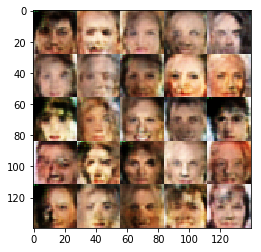

epoch 1 / 1 	 batch 2310 / ? 	 generator loss: 1.2954572439193726 	 discriminator loss: 0.7812373042106628
epoch 1 / 1 	 batch 2320 / ? 	 generator loss: 2.879096031188965 	 discriminator loss: 0.8081815838813782
epoch 1 / 1 	 batch 2330 / ? 	 generator loss: 1.572865605354309 	 discriminator loss: 0.7604809999465942
epoch 1 / 1 	 batch 2340 / ? 	 generator loss: 1.5660078525543213 	 discriminator loss: 0.6827556490898132
epoch 1 / 1 	 batch 2350 / ? 	 generator loss: 3.5288772583007812 	 discriminator loss: 0.5416333675384521
epoch 1 / 1 	 batch 2360 / ? 	 generator loss: 1.7600955963134766 	 discriminator loss: 0.6546505689620972
epoch 1 / 1 	 batch 2370 / ? 	 generator loss: 1.891397476196289 	 discriminator loss: 0.6739159822463989
epoch 1 / 1 	 batch 2380 / ? 	 generator loss: 2.369760036468506 	 discriminator loss: 0.6264950037002563
epoch 1 / 1 	 batch 2390 / ? 	 generator loss: 1.8271957635879517 	 discriminator loss: 0.6736190915107727
epoch 1 / 1 	 batch 2400 / ? 	 generator 

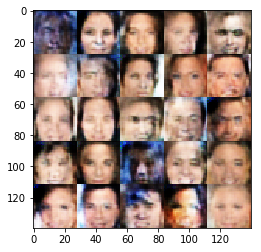

epoch 1 / 1 	 batch 2410 / ? 	 generator loss: 1.111673355102539 	 discriminator loss: 0.8704467415809631
epoch 1 / 1 	 batch 2420 / ? 	 generator loss: 1.0411145687103271 	 discriminator loss: 0.8692748546600342
epoch 1 / 1 	 batch 2430 / ? 	 generator loss: 1.6586878299713135 	 discriminator loss: 0.8838413953781128
epoch 1 / 1 	 batch 2440 / ? 	 generator loss: 1.1507209539413452 	 discriminator loss: 0.9463261961936951
epoch 1 / 1 	 batch 2450 / ? 	 generator loss: 3.3413443565368652 	 discriminator loss: 0.5597941875457764
epoch 1 / 1 	 batch 2460 / ? 	 generator loss: 0.7775826454162598 	 discriminator loss: 1.1372517347335815
epoch 1 / 1 	 batch 2470 / ? 	 generator loss: 1.315070629119873 	 discriminator loss: 0.8549080491065979
epoch 1 / 1 	 batch 2480 / ? 	 generator loss: 1.6274638175964355 	 discriminator loss: 0.8064618110656738
epoch 1 / 1 	 batch 2490 / ? 	 generator loss: 1.272634506225586 	 discriminator loss: 0.8536031246185303
epoch 1 / 1 	 batch 2500 / ? 	 generator

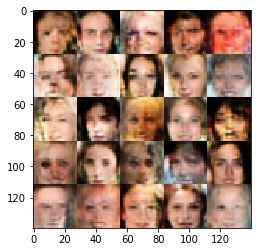

epoch 1 / 1 	 batch 2510 / ? 	 generator loss: 2.6204514503479004 	 discriminator loss: 0.7114813327789307
epoch 1 / 1 	 batch 2520 / ? 	 generator loss: 2.6292402744293213 	 discriminator loss: 0.6163288354873657
epoch 1 / 1 	 batch 2530 / ? 	 generator loss: 3.0994081497192383 	 discriminator loss: 0.5226159691810608
epoch 1 / 1 	 batch 2540 / ? 	 generator loss: 1.6604359149932861 	 discriminator loss: 0.6731383800506592
epoch 1 / 1 	 batch 2550 / ? 	 generator loss: 0.9112833738327026 	 discriminator loss: 1.023841142654419
epoch 1 / 1 	 batch 2560 / ? 	 generator loss: 0.7600825428962708 	 discriminator loss: 1.145160436630249
epoch 1 / 1 	 batch 2570 / ? 	 generator loss: 1.9206119775772095 	 discriminator loss: 0.6838977932929993
epoch 1 / 1 	 batch 2580 / ? 	 generator loss: 1.9245400428771973 	 discriminator loss: 0.5983010530471802
epoch 1 / 1 	 batch 2590 / ? 	 generator loss: 1.6374262571334839 	 discriminator loss: 0.6441619396209717
epoch 1 / 1 	 batch 2600 / ? 	 generato

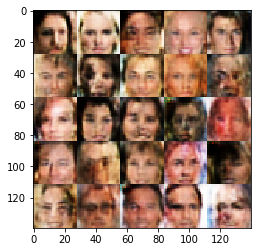

epoch 1 / 1 	 batch 2610 / ? 	 generator loss: 1.5864589214324951 	 discriminator loss: 0.7470840215682983
epoch 1 / 1 	 batch 2620 / ? 	 generator loss: 1.425993800163269 	 discriminator loss: 0.718891978263855
epoch 1 / 1 	 batch 2630 / ? 	 generator loss: 0.8226441144943237 	 discriminator loss: 1.0638773441314697
epoch 1 / 1 	 batch 2640 / ? 	 generator loss: 1.608367681503296 	 discriminator loss: 0.6698089241981506
epoch 1 / 1 	 batch 2650 / ? 	 generator loss: 4.6461920738220215 	 discriminator loss: 0.5124778747558594
epoch 1 / 1 	 batch 2660 / ? 	 generator loss: 1.9933280944824219 	 discriminator loss: 0.6187784671783447
epoch 1 / 1 	 batch 2670 / ? 	 generator loss: 1.087505578994751 	 discriminator loss: 0.8999228477478027
epoch 1 / 1 	 batch 2680 / ? 	 generator loss: 1.440131425857544 	 discriminator loss: 0.8892341256141663
epoch 1 / 1 	 batch 2690 / ? 	 generator loss: 0.9835655689239502 	 discriminator loss: 0.9533275365829468
epoch 1 / 1 	 batch 2700 / ? 	 generator l

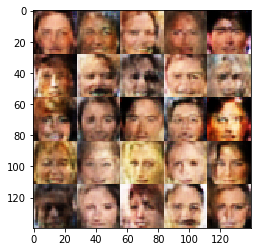

epoch 1 / 1 	 batch 2710 / ? 	 generator loss: 2.1403186321258545 	 discriminator loss: 1.166610836982727
epoch 1 / 1 	 batch 2720 / ? 	 generator loss: 1.7084161043167114 	 discriminator loss: 0.7223271131515503
epoch 1 / 1 	 batch 2730 / ? 	 generator loss: 1.534440040588379 	 discriminator loss: 0.7036018967628479
epoch 1 / 1 	 batch 2740 / ? 	 generator loss: 1.865638017654419 	 discriminator loss: 0.6237510442733765
epoch 1 / 1 	 batch 2750 / ? 	 generator loss: 2.2443997859954834 	 discriminator loss: 0.9105665683746338
epoch 1 / 1 	 batch 2760 / ? 	 generator loss: 1.1065179109573364 	 discriminator loss: 1.0503981113433838
epoch 1 / 1 	 batch 2770 / ? 	 generator loss: 0.4893544912338257 	 discriminator loss: 1.5565605163574219
epoch 1 / 1 	 batch 2780 / ? 	 generator loss: 1.3351173400878906 	 discriminator loss: 0.9022599458694458
epoch 1 / 1 	 batch 2790 / ? 	 generator loss: 2.0772552490234375 	 discriminator loss: 0.5767998695373535
epoch 1 / 1 	 batch 2800 / ? 	 generator

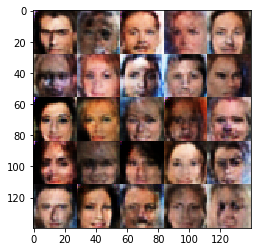

epoch 1 / 1 	 batch 2810 / ? 	 generator loss: 1.6117877960205078 	 discriminator loss: 0.6918804049491882
epoch 1 / 1 	 batch 2820 / ? 	 generator loss: 1.4767262935638428 	 discriminator loss: 0.8548453450202942
epoch 1 / 1 	 batch 2830 / ? 	 generator loss: 1.51149582862854 	 discriminator loss: 0.7473415732383728
epoch 1 / 1 	 batch 2840 / ? 	 generator loss: 1.29832923412323 	 discriminator loss: 0.7963813543319702
epoch 1 / 1 	 batch 2850 / ? 	 generator loss: 1.9675586223602295 	 discriminator loss: 0.7430141568183899
epoch 1 / 1 	 batch 2860 / ? 	 generator loss: 1.7516961097717285 	 discriminator loss: 0.7800034284591675
epoch 1 / 1 	 batch 2870 / ? 	 generator loss: 2.1860904693603516 	 discriminator loss: 0.5943102836608887
epoch 1 / 1 	 batch 2880 / ? 	 generator loss: 1.4561996459960938 	 discriminator loss: 0.7085310220718384
epoch 1 / 1 	 batch 2890 / ? 	 generator loss: 1.5671823024749756 	 discriminator loss: 0.6647336483001709
epoch 1 / 1 	 batch 2900 / ? 	 generator 

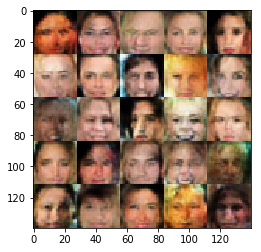

epoch 1 / 1 	 batch 2910 / ? 	 generator loss: 1.542513370513916 	 discriminator loss: 1.4955189228057861
epoch 1 / 1 	 batch 2920 / ? 	 generator loss: 1.1152386665344238 	 discriminator loss: 0.9026615023612976
epoch 1 / 1 	 batch 2930 / ? 	 generator loss: 1.2457554340362549 	 discriminator loss: 0.8392711877822876
epoch 1 / 1 	 batch 2940 / ? 	 generator loss: 1.1549692153930664 	 discriminator loss: 0.9550145268440247
epoch 1 / 1 	 batch 2950 / ? 	 generator loss: 1.1982920169830322 	 discriminator loss: 0.8104379177093506
epoch 1 / 1 	 batch 2960 / ? 	 generator loss: 1.1859047412872314 	 discriminator loss: 0.7937444448471069
epoch 1 / 1 	 batch 2970 / ? 	 generator loss: 1.880165934562683 	 discriminator loss: 0.7011852860450745
epoch 1 / 1 	 batch 2980 / ? 	 generator loss: 1.533940076828003 	 discriminator loss: 0.680383026599884
epoch 1 / 1 	 batch 2990 / ? 	 generator loss: 1.1026582717895508 	 discriminator loss: 0.8267967700958252
epoch 1 / 1 	 batch 3000 / ? 	 generator 

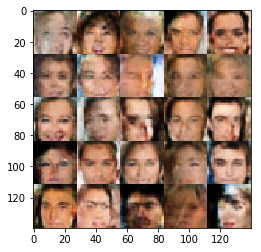

epoch 1 / 1 	 batch 3010 / ? 	 generator loss: 1.463017225265503 	 discriminator loss: 0.7016276121139526
epoch 1 / 1 	 batch 3020 / ? 	 generator loss: 0.1654338240623474 	 discriminator loss: 2.5854482650756836
epoch 1 / 1 	 batch 3030 / ? 	 generator loss: 2.2606396675109863 	 discriminator loss: 1.031420350074768
epoch 1 / 1 	 batch 3040 / ? 	 generator loss: 0.6587629318237305 	 discriminator loss: 1.2623742818832397
epoch 1 / 1 	 batch 3050 / ? 	 generator loss: 1.2196998596191406 	 discriminator loss: 0.8056058883666992
epoch 1 / 1 	 batch 3060 / ? 	 generator loss: 0.4583832025527954 	 discriminator loss: 1.4581242799758911
epoch 1 / 1 	 batch 3070 / ? 	 generator loss: 1.3657102584838867 	 discriminator loss: 0.7667097449302673
epoch 1 / 1 	 batch 3080 / ? 	 generator loss: 1.3524644374847412 	 discriminator loss: 0.814620852470398
epoch 1 / 1 	 batch 3090 / ? 	 generator loss: 1.6974653005599976 	 discriminator loss: 0.6715773344039917
epoch 1 / 1 	 batch 3100 / ? 	 generator

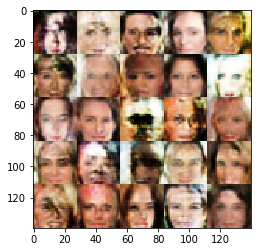

epoch 1 / 1 	 batch 3110 / ? 	 generator loss: 1.0321919918060303 	 discriminator loss: 0.888857364654541
epoch 1 / 1 	 batch 3120 / ? 	 generator loss: 3.304168939590454 	 discriminator loss: 0.6040177941322327
epoch 1 / 1 	 batch 3130 / ? 	 generator loss: 1.9083877801895142 	 discriminator loss: 0.5982885360717773
epoch 1 / 1 	 batch 3140 / ? 	 generator loss: 1.8837106227874756 	 discriminator loss: 0.6547163724899292
epoch 1 / 1 	 batch 3150 / ? 	 generator loss: 0.9786165952682495 	 discriminator loss: 0.8884475231170654
epoch 1 / 1 	 batch 3160 / ? 	 generator loss: 1.1330900192260742 	 discriminator loss: 0.8588141202926636


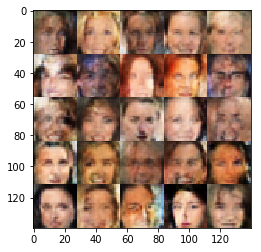

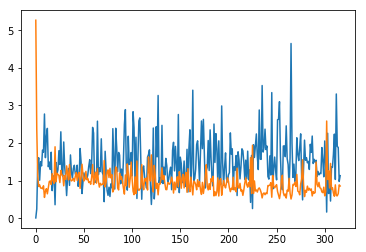

In [15]:
batch_size = 64
z_dim = 100
learning_rate = .00015
beta1 = .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.